# Introduction and Objectives

This project explores the potential of enhancing LLM performance through fine-tuning on brand-specific web data (RefinedWeb) for retail-focused applications. The objective is to improve the visibility and relevance of AI-driven search for businesses that deploy LLMs across websites, support bots, and internal tools. By leveraging fine-tuned models and curated web datasets, the project aims to deliver actionable insights in areas such as brand perception, competitive intelligence, SEO, and campaign optimization.

The overview of the project can be seen in this: [Link](https://docs.google.com/presentation/d/1osce2ePtygd-iho5KEaUy4Jbj97VoPYKr5bpKfSYxWY/edit?usp=sharing)

**Note**: 
- In the initial phase, the project will proceed on-premise, which has limited memory usage and RAM; therefore, it will start with a small scale. - The Apache Spark application is needed to scale up to large-scale processing.
- Additional space has been received for 32 GB in Ai8 Server.

# Table of Contents

1. [Notebook Setup](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/tree/digitas-analysis-shared/%5BTo-shared%5D%20analysis-ai-lab.ipynb#1-Notebook-Setup)

2. [Loading the Data](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/tree/digitas-analysis-shared/%5BTo-shared%5D%20analysis-ai-lab.ipynb#2-Loading-the-Data)

3. [Data Exploration](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/tree/digitas-analysis-shared/%5BTo-shared%5D%20analysis-ai-lab.ipynb#3-Data-Exploration)

4. [Data Preparation](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/tree/digitas-analysis-shared/%5BTo-shared%5D%20analysis-ai-lab.ipynb#4-Data-Preparation)

   - [4.1 Data Cleaning](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/tree/digitas-analysis-shared/%5BTo-shared%5D%20analysis-ai-lab.ipynb#4.1-Data-Cleaning)
   - [4.2 Handling null values](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/tree/digitas-analysis-shared/%5BTo-shared%5D%20analysis-ai-lab.ipynb#4.2-Handling-null-values)
   - [4.3 Word cloud analysis](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/tree/digitas-analysis-shared/%5BTo-shared%5D%20analysis-ai-lab.ipynb#4.3-Word-cloud-analysis)
   - [4.4 Feature Engineering](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/tree/digitas-analysis-shared/%5BTo-shared%5D%20analysis-ai-lab.ipynb#4.4-Feature-Engineering)
   - [4.5 Data Categorization](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/tree/digitas-analysis-shared/%5BTo-shared%5D%20analysis-ai-lab.ipynb#4.5-Data-Categorization)
   - [4.6 Final Dataset Dictionary](https://app.ai8.io/user/thanchanok.puranamaneewiwat.24@ucl.ac.uk/lab/tree/digitas-analysis-shared/%5BTo-shared%5D%20analysis-ai-lab.ipynb#4.6-Final-Dataset-Dictionary)



# 1 Notebook Setup

## Requirement

In [1]:
from IPython.utils import io

with io.capture_output() as captured:
    !pip install -r requirements.txt
    !pip install pyspark
    !pip install pyspark datasets
    !pip install wordcloud
    !pip install vaderSentiment

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import pandas as pd
import gc  # Import the garbage collection module
import nltk
import pandas as pd
import numpy as np
import dateutil
import datetime as dt

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import explode, split, lower, col
import pandas as pd
from itertools import islice
from datasets import load_dataset
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import year, to_timestamp
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import count
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.sql.functions import count
from pyspark.sql import Row
from pyspark.sql.functions import when, col
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.functions import when, col
from pyspark.sql.types import StringType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import regexp_extract, col, length, lower, size, split, instr
from pyspark.sql.functions import regexp_extract, split, col, size, lower, instr, concat_ws
from pyspark.sql.functions import concat_ws, lpad
from pyspark.sql import SparkSession

from pyspark.sql.functions import lit, col, lower
from pyspark.sql.functions import instr
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, year, weekofyear
from pyspark.sql.functions import to_date, col, year, weekofyear
from pyspark.sql.functions import lit

from pyspark.sql.functions import expr




## Defined function

**Purpose:**

This function is designed to reduce the memory usage of a pandas DataFrame by downcasting numeric types and converting object columns to categories. This is especially useful for large datasets used in machine learning and NLP pipelines.

**Benefits:**
- Saves RAM during model training, especially on large text datasets
- Makes preprocessing pipelines more efficient
- Helps avoid memory bottlenecks on limited hardware


**Limitations:**
- **Float precision loss:** Using `float16` or `float32` might affect model performance if high precision is needed (e.g., embeddings, logits)
- **Categorical conversion:** Converting string columns to categories is memory-efficient, but may not be ideal if the column contains many unique values (e.g., full sentences)
- **No automatic conversion back:** Once converted, original data types are lost unless explicitly saved
- **Not GPU-aware:** Does not account for compatibility with GPU-based libraries like TensorFlow or PyTorch, which might require specific dtypes

**Recommendation:**

Use this function on numeric IDs, flags, and metadata,not directly on raw embeddings or floating-point model inputs unless you're sure precision loss won't hurt performance.

In [26]:
# # Set chained_assignment to 'None' to suppress SettingWithCopyWarning
# chained_assignment = None

# def reduce_memory_usage(df):
#     """
#     Reduce memory usage of a Pandas DataFrame by downcasting numeric columns
#     and converting object columns to categorical, where appropriate.
#     """

#     start_mem = df.memory_usage(deep=True).sum() / 1024**2
#     print(f"Initial memory usage: {start_mem:.2f} MB")

#     for col in df.columns:
#         col_type = df[col].dtype

#         if pd.api.types.is_numeric_dtype(col_type):
#             # For numeric columns, attempt to downcast to smaller types
#             c_min = df[col].min()
#             c_max = df[col].max()

#             if pd.api.types.is_integer_dtype(col_type):
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 else:
#                     df[col] = df[col].astype(np.int64)
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)

#         elif pd.api.types.is_bool_dtype(col_type):
#             # Leave boolean columns as-is
#             df[col] = df[col].astype(bool)

#         elif pd.api.types.is_datetime64_any_dtype(col_type):
#             # Leave datetime columns unchanged
#             continue

#         elif pd.api.types.is_object_dtype(col_type):
#             # Skip conversion if the column contains complex types (e.g., lists or dicts)
#             if df[col].apply(lambda x: isinstance(x, (list, dict))).any():
#                 continue
#             try:
#                 df[col] = df[col].astype("category")
#             except Exception as e:
#                 print(f"Skipped column '{col}' (object to category): {e}")
#                 continue

#     end_mem = df.memory_usage(deep=True).sum() / 1024**2
#     print(f"Optimized memory usage: {end_mem:.2f} MB")
#     print(f"Reduction: {100 * (start_mem - end_mem) / start_mem:.1f}%")

#     return df

# 2 Loading the Data

The dataset path is predefined in `path.txt`, located in the `parquet_data` folder. Use the `download_parquet.sh` script to retrieve the data based on the paths listed in this file. After downloading the Parquet files (15 files in this case), use the `filter_primark_duckdb.py` module to filter for records containing the keyword **Primark**, or alternatively, use `filter_brand_duckdb.py` to select multiple retail brands such as **H&M**, **Next** and **Primark**.  
For this project, we will proceed with **Primark** as the target brand for preliminary analysis.

In [6]:
# Set the folder path
folder_path = "parquet_data"

# List all files and their sizes in bytes, excluding paths.txt
file_sizes = []
for filename in os.listdir(folder_path):
    if filename == "paths.txt":
        continue  # Skip paths.txt
    filepath = os.path.join(folder_path, filename)
    if os.path.isfile(filepath):
        size_bytes = os.path.getsize(filepath)
        file_sizes.append({
            "File Name": filename,
            "Size (MB)": round(size_bytes / (1024 * 1024), 2)
        })

# Convert to DataFrame
df_sizes = pd.DataFrame(file_sizes).sort_values(by="Size (MB)", ascending=False)

# Count number of files (excluding paths.txt)
file_count = len(file_sizes)
print(f"Number of files in '{folder_path}': {file_count}")

# Calculate and display total size
total_size_mb = df_sizes["Size (MB)"].sum()
total_size_gb = round(total_size_mb / 1024, 2)
print(f"Total size of files in '{folder_path}': {total_size_gb:.2f} GB")

# Display table
from IPython.display import display
display(df_sizes)

Number of files in 'parquet_data': 56
Total size of files in 'parquet_data': 15.93 GB


,File Name,Size (MB)
54,train-00500-of-05534-6fd02adc5942f4fd.parquet,320.18
10,train-00017-of-05534-81d837539550c007.parquet,309.15
21,train-00057-of-05534-3fe06a60d8b3ba1f.parquet,308.34
48,train-00038-of-05534-422efc900cd120fe.parquet,306.44
19,train-00012-of-05534-acf3fb5fee2b7e50.parquet,305.87
42,train-00018-of-05534-6d374c09460d8143.parquet,305.82
53,train-00036-of-05534-75f410e082912165.parquet,300.00
44,train-03500-of-05534-aae8ffe7df807731.parquet,299.86
18,train-00000-of-05534-b8fc5348cbe605a5.parquet,299.27
6,train-00019-of-05534-724cfbde611d86f5.parquet,296.45


In [7]:
# Load java if you have not downloaded yet
# !wget https://builds.openlogic.com/downloadJDK/openlogic-openjdk/11.0.22+7/openlogic-openjdk-11.0.22+7-linux-x64.tar.gz
# !tar -xzf openlogic-openjdk-11.0.22+7-linux-x64.tar.gz

In [4]:
# Set the java path
java_path = os.path.abspath("openlogic-openjdk-11.0.22+7-linux-x64")
os.environ["JAVA_HOME"] = java_path
os.environ["PATH"] = java_path + "/bin:" + os.environ["PATH"]

In [5]:
!$JAVA_HOME/bin/java -version

openjdk version "11.0.22" 2024-01-16
OpenJDK Runtime Environment OpenLogic-OpenJDK (build 11.0.22+7-adhoc.root.jdk11u)
OpenJDK 64-Bit Server VM OpenLogic-OpenJDK (build 11.0.22+7-adhoc.root.jdk11u, mixed mode)


In [10]:
# ALL files download
!ls -lh parquet_data/

total 12K
-rw-r--r-- 1 jovyan users 9.6K May 19 15:32 paths.txt


## Memory Management

To manage memory usage efficiently, this project **deletes all downloaded data files** after running `filtered_primark_duckdb`, which filters only the relevant brand (`Primark`).

This prevents storage overload, especially when working with large `.parquet` datasets. 

The following code removes all `.parquet` files from the folder after filtering is complete, keeping only necessary references like `paths.txt`.

In [16]:
# Get and display the current working directory for file verification
# The environment is based on a Jupyter container with the default 'jovyan' user, as configured by the server.
current_directory = os.getcwd()

### Delete download data

Run this code below **after running Duckdb 
filtered module**. This code have been hidden in initial stage to keep log of dataset comprehensively

In [10]:
# Folder containing the parquet files
folder_path = current_directory + "/parquet_data"

# List and delete .parquet files only
for file in os.listdir(folder_path):
    if file.endswith(".parquet"):
        file_path = os.path.join(folder_path, file)
        os.remove(file_path)
        print(f"Deleted: {file}")

Deleted: train-00051-of-05534-b8a6dc2a89918893.parquet
Deleted: train-00039-of-05534-9b84156534f2e079.parquet
Deleted: train-00028-of-05534-09ffe38fe3bb6c59.parquet
Deleted: train-00025-of-05534-364c4d103a621e0f.parquet
Deleted: train-00030-of-05534-bfbcdce619c0f298.parquet
Deleted: train-00008-of-05534-8ed029166c6795cf.parquet
Deleted: train-00019-of-05534-724cfbde611d86f5.parquet
Deleted: train-00023-of-05534-68a7ffc65bb0793d.parquet
Deleted: train-00062-of-05534-84e72000997f426c.parquet
Deleted: train-00035-of-05534-4af1fa8b5ec251d2.parquet
Deleted: train-00017-of-05534-81d837539550c007.parquet
Deleted: train-00029-of-05534-fd33dccd28c51349.parquet
Deleted: train-00016-of-05534-0e0c9b82ed6ccecc.parquet
Deleted: train-00010-of-05534-5373970b3705bfc5.parquet
Deleted: train-01000-of-05534-2f5aada1ebdf607f.parquet
Deleted: train-00027-of-05534-bddc08d9377fbb66.parquet
Deleted: train-00031-of-05534-ee852b432a95e05a.parquet
Deleted: train-00037-of-05534-378fea92f8c1f986.parquet
Deleted: t

Due to limited memory availability, especially when working with large datasets or converting Spark DataFrames to Pandas, it is important to explicitly release memory used by temporary objects. 

This helps avoid memory overflow issues and keeps the notebook session responsive.

Use `del` to delete unnecessary DataFrames and `gc.collect()` to trigger garbage collection and reclaim RAM.

In [11]:
gc.collect()

0

# 3 Data Exploration

## Data Dictionary

### Falcon RefinedWeb - Original Dataset

| Field Name   | Type              | Description                                                                 |
|--------------|-------------------|-----------------------------------------------------------------------------|
| `content`    | string            | Raw textual content extracted from a web page                              |
| `url`        | string            | The original URL of the crawled web page                                   |
| `timestamp`  | timestamp (string)| The date and time when the page was crawled by CommonCrawl (not publish time) |
| `dump`       | string            | Identifier for the specific CommonCrawl snapshot (e.g., `CC-MAIN-2013-20`)  |
| `segment`    | string            | Internal segment identifier within the crawl dump                          |
| `image_urls` | list of strings   | List of image URLs found on the web page (may be empty if no images exist) |


Datasource: [Link](https://huggingface.co/datasets/tiiuae/falcon-refinedweb)

## Spark Application for Preprocessing

The Spark job architecture used in this project is built on a reusable framework defined in `sparkcc.py`, which provides a flexible base class (`CCSparkJob`) for processing Common Crawl data using PySpark. This modular design separates concerns such as argument parsing, I/O handling, and distributed processing logic, making it easy to extend and customize for different analysis tasks.

The specific job used for this project is `word_count_parquet.py`, which extends `CCSparkJob` to perform word frequency analysis on a local Parquet dataset (e.g., `primark.parquet`). This job reads the `content` column from the dataset, tokenizes text into lowercase words, and computes two metrics:
- **Term Frequency (TF):** The total number of times each word appears across the entire dataset.
- **Document Frequency (DF):** The number of unique documents each word appears in.
`
Text tokenization is handled using PySpark functions such as `explode`, `split`, and `lower`, and results are aggregated using `groupBy` and `count`. The job constructs a final output in the form of an RDD of key-value pairs, where the key is the word and the value is a dictionary containing both TF and DF counts.

The results are written to the default Spark SQL warehouse as a managed table or to a specified output directory in Parquet format. The job uses the output compression and formatting options specified via command-line arguments.

This implementation is adapted from the original [Common Crawl Spark word count job](https://github.com/commoncrawl/cc-pyspark/blob/main/word_count.py), replacing the raw WARC processing with a direct Parquet input workflow. This adaptation simplifies processing for brand-filtered datasets and improves performance by avoiding external file streaming.

To execute the job, run `word_count_parquet.py` with the appropriate `--input` and `--output` arguments. The output will be written to the `spark-warehouse` folder or the specified destination in Parquet format.

In [6]:
# Initialize Spark with memory config, Allocate up to 16 GB of RAM for the Spark driver process
spark = SparkSession.builder \
    .appName("RefinedWebAnalysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .getOrCreate()

# Set log level to show only ERROR and above (suppress INFO/WARN)
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/20 01:38:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Check Memory Usage of Parquet File

In [17]:
folder_path = current_directory + "/filtered_data/primark.parquet"
file_path = "filtered_data/primark.parquet"

In [18]:
# Total size of all files in the Parquet directory
file_size_bytes = os.path.getsize(file_path)
file_size_mb = file_size_bytes / (1024 * 1024 *1024)

print(f"Approximate Parquet file size: {file_size_mb:.2f} GB")

Approximate Parquet file size: 0.01 GB


### Basic Metadata

In [19]:
df = spark.read.parquet("filtered_data/primark.parquet")
df.createOrReplaceTempView("primark")

In [20]:
# Count Total Rows
spark.sql("SELECT COUNT(*) FROM primark").show()

+--------+
|count(1)|
+--------+
|    1389|
+--------+



In [21]:
# Check Schema
df.printSchema()

root
 |-- content: string (nullable = true)
 |-- url: string (nullable = true)
 |-- timestamp: timestamp_ntz (nullable = true)
 |-- dump: string (nullable = true)
 |-- segment: string (nullable = true)
 |-- image_urls: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)



In [22]:
# Preview top 10 rows as DataFrame
preview_df = spark.sql("SELECT * FROM primark LIMIT 10")
preview_df.show(5)  # disable truncation of long strings

+--------------------+--------------------+-------------------+---------------+-------------+--------------------+
|             content|                 url|          timestamp|           dump|      segment|          image_urls|
+--------------------+--------------------+-------------------+---------------+-------------+--------------------+
|I wore this very ...|http://www.beingl...|2013-05-18 10:41:14|CC-MAIN-2013-20|1368696382261|[[http://farm7.st...|
|It was a beautifu...|http://www.meek-n...|2013-05-18 10:21:41|CC-MAIN-2013-20|1368696382261|[[http://1.bp.blo...|
|I tried out this ...|http://aestheticc...|2013-05-18 10:21:14|CC-MAIN-2013-20|1368696382261|                  []|
| »\nTime Juggling...|http://unravelcat...|2013-05-18 10:52:32|CC-MAIN-2013-20|1368696382261|[[http://distille...|
|Advantages Cheap ...|http://www.ciao.c...|2013-05-18 10:12:59|CC-MAIN-2013-20|1368696382261|                  []|
+--------------------+--------------------+-------------------+---------------+-

## Spark SQL & pandas Dataframe

To inspect full text fields (such as long sentences) more easily, it's often helpful to convert Spark SQL results into a pandas DataFrame. This enables better formatting and interaction in notebooks.

### Understanding df.toPandas() Memory Issue

Using `df.toPandas()` loads the entire DataFrame into the Driver's RAM, which can cause memory errors if the dataset is too large. This often results in connection failures, but limiting the data size (e.g., `df.limit(1000).toPandas()`) works because it stays within memory limits. The issue is due to insufficient RAM for the full dataset.

In [29]:
# Show full column width for all text columns
pd.set_option('display.max_colwidth', None)

In [31]:
# Convert Spark DataFrame to Pandas (แค่ 1000 แถว)
pdf = df.limit(1000).toPandas()

# Preview
pdf.head()

content  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [32]:
pd.reset_option('display.max_colwidth')

### Memory Management

In [33]:
# Once done, explicitly delete the Pandas DataFrame to free memory
del pdf  # Removes the variable reference

# Force garbage collection to reclaim memory from RAM
gc.collect()  # Ensures Python releases unused memory immediately

411

In [36]:
gc.collect()

0

### Time-Based Analysis

In [37]:

spark.sql("""
    SELECT 
        MIN(timestamp) AS earliest_date,
        MAX(timestamp) AS latest_date
    FROM primark
""").show()

+-------------------+-------------------+
|      earliest_date|        latest_date|
+-------------------+-------------------+
|2008-05-16 00:04:10|2022-09-25 08:41:11|
+-------------------+-------------------+



In [38]:
# Number of records per year (using SQL)
# First, ensure the timestamp column is cast properly
df_with_year = spark.sql("""
    SELECT *, YEAR(TO_TIMESTAMP(timestamp)) AS year 
    FROM primark
""")
df_with_year.createOrReplaceTempView("primark_with_year")

spark.sql("""
    SELECT 
        year, 
        COUNT(*) AS records 
    FROM primark_with_year 
    GROUP BY year 
    ORDER BY year
""").show()

+----+-------+
|year|records|
+----+-------+
|2008|      1|
|2009|      6|
|2012|     10|
|2013|     12|
|2014|     49|
|2015|     31|
|2016|     19|
|2017|    321|
|2018|    260|
|2019|    222|
|2020|    151|
|2021|    214|
|2022|     93|
+----+-------+



The records from 2008 to 2012 were filtered out because they account for a relatively small portion of the dataset and may not reflect the more current patterns of web content. These early years have significantly fewer entries compared to later periods, which could introduce temporal bias or inconsistencies in model training. By focusing on data from 2013 onward, we ensure a more robust, relevant, and balanced dataset that better represents modern web usage and language.

In [39]:
# Add 'year' column and filter rows in one chain
df_filtered = df.withColumn("year", year(to_timestamp("timestamp"))) \
                .filter((col("year") >= 2014) & (col("year") <= 2022))

In [40]:
# After removals, Group by year and count records
df_filtered.groupBy("year").count().orderBy("year").show()

+----+-----+
|year|count|
+----+-----+
|2014|   49|
|2015|   31|
|2016|   19|
|2017|  321|
|2018|  260|
|2019|  222|
|2020|  151|
|2021|  214|
|2022|   93|
+----+-----+



### Saved as new parquet files (Checkpoint)

**Note:** The code block below has been intentionally hidden to prevent unintentional multiple downloads of the dataset. This is a best practice to avoid redundant operations that may consume unnecessary resources or lead to duplicate file writes.

In [46]:
# Save filtered data as a single files
# filtered_path = "filtered_data/primark_2014_2022.parquet"
# df_filtered.coalesce(1).write.mode("overwrite").option("compression", "snappy").parquet(filtered_path)

In [48]:
# Delete old dataframe
# del df
gc.collect()

1406

In [43]:
gc.collect()

0

### Create new temporary view

In [49]:
df_filtered.createOrReplaceTempView("primark_filtered")

In [53]:
# Full path to the actual parquet file (not the folder)
filtered_year_path = "filtered_data/primark_2014_2022.parquet/part-00000-ccc34394-9e40-4c0c-bae9-5410fcd67533-c000.snappy.parquet"

# Read the single Parquet file
df_filtered = spark.read.parquet(filtered_year_path)

# Show basic info
df_filtered.show(5)
df_filtered.printSchema()

+--------------------+--------------------+-------------------+---------------+---------------+----------+----+
|             content|                 url|          timestamp|           dump|        segment|image_urls|year|
+--------------------+--------------------+-------------------+---------------+---------------+----------+----+
|- pretty petunia ...|https://drupalthe...|2019-12-05 17:20:47|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|\nRegular Industr...|https://sctimes.i...|2019-12-05 18:35:10|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|Sitemap Gallery L...|http://eddyindia....|2019-12-05 16:53:03|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|Top - Primark\nJe...|http://www.ellen-...|2019-12-05 17:06:45|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|I can't believe t...|https://www.burka...|2019-12-05 17:53:30|CC-MAIN-2019-51|1575540481281.1|        []|2019|
+--------------------+--------------------+-------------------+---------------+---------------+---------

### Check File Size of filtered Parquet File

In [55]:
# Get file size in bytes
file_size_bytes = os.path.getsize(filtered_year_path)

# Convert to megabytes (MB)
file_size_gb = file_size_bytes / (1024 ** 2)

# Print sizes
print(f"File size: ({file_size_gb:.2f} MB)")

File size: (7.22 MB)


### Null / Missing Value Counts

While the Refinedweb dataset is designed to minimize missing values it's important note that given its web-based origins some instances might still contain incomplete or less informative content. It is a good practice check null  during exploring the data  

In [56]:
spark.sql("""
    SELECT
        SUM(CASE WHEN content IS NULL THEN 1 ELSE 0 END) AS null_content,
        SUM(CASE WHEN url IS NULL THEN 1 ELSE 0 END) AS null_url,
        SUM(CASE WHEN timestamp IS NULL THEN 1 ELSE 0 END) AS null_timestamp,
        SUM(CASE WHEN dump IS NULL THEN 1 ELSE 0 END) AS null_dump,
        SUM(CASE WHEN segment IS NULL THEN 1 ELSE 0 END) AS null_segment,
        SUM(CASE WHEN image_urls IS NULL THEN 1 ELSE 0 END) AS null_image_urls
    FROM primark_filtered
""").show()

+------------+--------+--------------+---------+------------+---------------+
|null_content|null_url|null_timestamp|null_dump|null_segment|null_image_urls|
+------------+--------+--------------+---------+------------+---------------+
|           0|       0|             0|        0|           0|              0|
+------------+--------+--------------+---------+------------+---------------+



The analysis confirms that there are **no null values** across all key fields in the dataset (`content`, `url`, `timestamp`, `dump`, `segment`, `image_urls`). This indicates a **high level of data completeness and quality**, which is essential for ensuring robust and uninterrupted downstream processing such as filtering, modeling, and NLP tasks. No additional data cleaning is required for handling missing entries at this stage.

### Distinct Counts & Duplicate Detection

In [57]:
spark.sql("""
    SELECT
        COUNT(*) AS total_rows,
        COUNT(DISTINCT url) AS distinct_urls,
        COUNT(DISTINCT dump) AS distinct_dumps,
        COUNT(DISTINCT segment) AS distinct_segments
    FROM primark_filtered
""").show()

+----------+-------------+--------------+-----------------+
|total_rows|distinct_urls|distinct_dumps|distinct_segments|
+----------+-------------+--------------+-----------------+
|      1360|         1360|            76|              170|
+----------+-------------+--------------+-----------------+



### URLs Frequent Value

In [58]:
spark.sql("""
    SELECT
        url,
        COUNT(*) AS occurrences
    FROM primark_filtered
    GROUP BY url
    ORDER BY occurrences DESC
    LIMIT 10
""").show(truncate=False)

+----------------------------------------------------------------------------------------------------+-----------+
|url                                                                                                 |occurrences|
+----------------------------------------------------------------------------------------------------+-----------+
|http://fragile-bird.blogspot.co.uk/2012_11_01_archive.html                                          |1          |
|http://totalmodisch.blogspot.com/2016/04/washed-out.html                                            |1          |
|https://www.coventrytelegraph.net/news/local-news/a-store-full-of-memories-3121036                  |1          |
|http://www.irishtimes.com/search/search-7.1213540?tag_organisation=Uni%2BGlobal%2BUnion&article=true|1          |
|http://loo-sleycrafting.blogspot.com/2008/01/throwing-down-gauntlet.html                            |1          |
|https://community.babycentre.co.uk/post/a33590338/weird-comforters-very-lighthe

The URL frequency analysis shows that most URLs in the dataset are unique, with the highest occurrence being just 2. This suggests that the content comes from a wide variety of web pages rather than being concentrated on a few sources. Such diversity is common in web-scraped corpora and indicates that the dataset captures a broad range of topics and domains, **which is beneficial for general-purpose language modeling.** However, it also implies that URL-based deduplication or clustering would offer limited value which they may **limit deduplication or source-based grouping strategies.**

### Text Field Length Stats (character length)

In [59]:
spark.sql("""
    SELECT
        MIN(LENGTH(content)) AS min_char_length,
        MAX(LENGTH(content)) AS max_char_length,
        ROUND(AVG(LENGTH(content)), 2) AS avg_char_length
    FROM primark_filtered
""").show()

+---------------+---------------+---------------+
|min_char_length|max_char_length|avg_char_length|
+---------------+---------------+---------------+
|             37|         258101|        9041.77|
+---------------+---------------+---------------+



The `primark_filtered` dataset shows varied text lengths: the shortest entry has 37 characters, while the longest reaches 624,268. On average, each record contains 9041 characters. **This suggests the dataset includes both concise and lengthy web content**. For efficient processing, consider trimming outliers or segmenting long entries, especially when applying NLP models.

### Empty image_urls lists

In [60]:
spark.sql("""
    SELECT
        COUNT(*) AS total_records,
        SUM(CASE WHEN SIZE(image_urls) = 0 THEN 1 ELSE 0 END) AS empty_image_lists
    FROM primark_filtered
""").show()

+-------------+-----------------+
|total_records|empty_image_lists|
+-------------+-----------------+
|         1360|              873|
+-------------+-----------------+



In [61]:
# Preview rows with empty image_urls list
spark.sql("""
    SELECT *
    FROM primark_filtered
    WHERE SIZE(image_urls) = 0
    LIMIT 10
""").show()

+--------------------+--------------------+-------------------+---------------+---------------+----------+----+
|             content|                 url|          timestamp|           dump|        segment|image_urls|year|
+--------------------+--------------------+-------------------+---------------+---------------+----------+----+
|- pretty petunia ...|https://drupalthe...|2019-12-05 17:20:47|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|\nRegular Industr...|https://sctimes.i...|2019-12-05 18:35:10|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|Sitemap Gallery L...|http://eddyindia....|2019-12-05 16:53:03|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|Top - Primark\nJe...|http://www.ellen-...|2019-12-05 17:06:45|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|I can't believe t...|https://www.burka...|2019-12-05 17:53:30|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|HUGE apologies fo...|http://www.little...|2019-12-05 16:48:49|CC-MAIN-2019-51|1575540481281.1|        [

RefinedWeb is a multimodal dataset; however, out of 265,316 total records in the `primark_filtered` subset, 170,506 (approximately 64%) contain empty `image_urls` lists, indicating the absence of associated image data. This suggests that a significant portion of the dataset is text-only, which may limit its suitability for tasks requiring image-text alignment.

### Using word_count spark jobs

In [62]:
word_count_file_path = current_directory + "/spark-warehouse/word_count/part-00000-6333f081-c9da-4b8d-b183-745978d528cf-c000.gz.parquet"
print(word_count_file_path)

df_word_count = spark.read.parquet(word_count_file_path)
df_word_count.show(20, truncate=False)

/home/jovyan/digitas-analysis-shared/spark-warehouse/word_count/part-00000-6333f081-c9da-4b8d-b183-745978d528cf-c000.gz.parquet
+------------+----------+
|key         |val       |
+------------+----------+
|few         |{233, 115}|
|some        |{575, 201}|
|marxism     |{5, 1}    |
|familia     |{1, 1}    |
|brands      |{125, 53} |
|travel      |{79, 30}  |
|outfit      |{297, 96} |
|art         |{237, 31} |
|recognize   |{5, 4}    |
|hope        |{117, 81} |
|those       |{235, 104}|
|inner       |{8, 8}    |
|cures       |{1, 1}    |
|safeguarding|{3, 2}    |
|pools       |{6, 4}    |
|blossom     |{13, 5}   |
|still       |{253, 121}|
|painters    |{1, 1}    |
|trail       |{5, 3}    |
|jewelry     |{31, 11}  |
+------------+----------+
only showing top 20 rows



In [63]:
df_word_count = spark.read.parquet(word_count_file_path)

# Extract and rename fields
df_word_count = df_word_count.select(
    col("key").alias("word"),
    col("val.tf").alias("term_frequency"),
    col("val.df").alias("document_frequency")
)

# Preview the new DataFrame
df_word_count.show(10, truncate=False)

+---------+--------------+------------------+
|word     |term_frequency|document_frequency|
+---------+--------------+------------------+
|few      |233           |115               |
|some     |575           |201               |
|marxism  |5             |1                 |
|familia  |1             |1                 |
|brands   |125           |53                |
|travel   |79            |30                |
|outfit   |297           |96                |
|art      |237           |31                |
|recognize|5             |4                 |
|hope     |117           |81                |
+---------+--------------+------------------+
only showing top 10 rows



In [64]:
df_word_count.orderBy(col("term_frequency").desc()).show(50, truncate=False)

+-----------+--------------+------------------+
|word       |term_frequency|document_frequency|
+-----------+--------------+------------------+
|the        |12779         |365               |
|and        |8713          |361               |
|to         |7300          |360               |
|a          |6582          |357               |
|of         |6358          |358               |
|i          |5926          |283               |
|in         |5134          |345               |
|for        |4659          |337               |
|it         |3367          |323               |
|with       |3184          |325               |
|is         |3052          |329               |
|you        |2595          |291               |
|on         |2587          |328               |
|that       |2492          |312               |
|s          |2347          |311               |
|this       |1958          |297               |
|my         |1705          |248               |
|up         |1601          |249         

In [65]:
df_word_count.orderBy(col("document_frequency").desc()).show(50, truncate=False)

+-------+--------------+------------------+
|word   |term_frequency|document_frequency|
+-------+--------------+------------------+
|primark|751           |371               |
|the    |12779         |365               |
|and    |8713          |361               |
|to     |7300          |360               |
|of     |6358          |358               |
|a      |6582          |357               |
|in     |5134          |345               |
|for    |4659          |337               |
|is     |3052          |329               |
|on     |2587          |328               |
|with   |3184          |325               |
|it     |3367          |323               |
|that   |2492          |312               |
|s      |2347          |311               |
|this   |1958          |297               |
|from   |1449          |293               |
|you    |2595          |291               |
|have   |1551          |290               |
|i      |5926          |283               |
|as     |1546          |282     

This table shows `term_frequency` (total word occurrences) and `document_frequency` (number of documents the word appears in). While most words are common and offer limited insight, the results show:

- **Stop Words**: High-frequency words like `the`, `to`, `and`, `of` are typical stop words. Recommended for removal during preprocessing.
- **Domain Term**: `primark` has the highest frequency—likely a domain-specific keyword and should be retained.
- **Balanced Words**: Words such as `you`, `have`, `can` appear frequently across documents—potentially useful for classification or sentiment analysis.

## Next Steps
- Retain domain-specific terms like `primark`.
- Use document frequency to inform feature selection.
- Proceed the preprocessing stages

In [66]:
# Remove unnecessary dataframes for memory optimisation
gc.collect()

1300

# 4 Data Preparation

### Preprocessing Guidelines for Fine-Tuning LLMs on RefinedWeb Data

RefinedWeb, having undergone Macro Data Refinement (MDR), provides a high-quality, large-scale web dataset suitable for training and fine-tuning transformer-based models such as GPT, BERT, and RoBERTa. Because these models rely on the full structure of natural language—including punctuation, casing, and contextual clues—only minimal and targeted preprocessing is appropriate.

Over-processing can strip away valuable linguistic signals, reduce vocabulary diversity, and ultimately degrade model performance. Instead, preprocessing should focus on removing structural noise while preserving the richness of real-world language.

#### What RefinedWeb Already Provides

- Script and boilerplate removal, leaving content-rich text
- Deduplication across domains to minimize redundancy
- Length-normalized documents for efficient batching
- English-only filtering for language consistency
- Format compatibility with standard LLM tokenizers

#### What preprocessing this project will do 

- **HTML Tag Removal**  
  Remove any remaining HTML or markup tags to retain clean, human-readable text.

- **Mention and Hashtag Cleanup**  
  Replace or standardize user mentions and hashtags depending on task relevance (e.g., `@user` → `[USER]`).

- **Light Normalization**  
  Eliminate residual non-content markers such as `[CAPTION]`, `[FIGURE]`, or other templated artifacts.

- **Emojis and Symbols**  
  Preserve or normalize emojis and symbols when relevant, especially in tasks involving sentiment or informal tone analysis.

#### Preprocessing Actions to Avoid

- **Stopword Removal**  
  Stopwords contribute to syntactic structure and semantic coherence. Their removal can confuse sequence models.

- **Lowercasing**  
  Casing often distinguishes proper nouns, sentence boundaries, or emphasis. It should be preserved, especially for cased models.

- **Lemmatization or Stemming**  
  These steps are unnecessary and potentially harmful, as LLMs are trained on surface-level word forms.

- **Spelling Correction**  
  RefinedWeb intentionally retains natural spelling variation to reflect real-world language use. Correcting spelling may reduce lexical diversity and misrepresent informal text.

- **Manual Tokenization**  
  Always use the model’s built-in tokenizer to ensure alignment with its pretrained vocabulary and subword segmentation.

### Conclusion

Minimal preprocessing is appropriate when fine-tuning LLMs on RefinedWeb. Efforts should focus on structural cleanup and task-specific tagging, while preserving the linguistic variation and contextual detail that large language models are designed to leverage. This balance ensures models remain sensitive to the subtle patterns in natural language and are better positioned to generalize across domains and tasks.


## 4.1 Data Cleaning

In [67]:
# Preview the content column
df_filtered.select("content").show()

+--------------------+
|             content|
+--------------------+
|- pretty petunia ...|
|\nRegular Industr...|
|Sitemap Gallery L...|
|Top - Primark\nJe...|
|I can't believe t...|
|HUGE apologies fo...|
|You have definite...|
|Mango. 10,927,203...|
|Is there any hope...|
|Travel Posts\nRoc...|
|Dress: H&M\nBag: ...|
|After the fun I h...|
|\nSep 2016\n- 5th...|
|This is an edited...|
|This time last ye...|
|Another week has ...|
|Tights: Primark\n...|
|Bairbre Power: Su...|
|Motel 24h Berlin\...|
|Yes, I jinxed us ...|
+--------------------+
only showing top 20 rows



### HTML Tag Removal

In [68]:
df_new = df_filtered.withColumn("content", regexp_replace("content", "<[^>]*>", ""))
df_new.show()

+--------------------+--------------------+-------------------+---------------+-----------------+--------------------+----+
|             content|                 url|          timestamp|           dump|          segment|          image_urls|year|
+--------------------+--------------------+-------------------+---------------+-----------------+--------------------+----+
|- pretty petunia ...|https://drupalthe...|2019-12-05 17:20:47|CC-MAIN-2019-51|  1575540481281.1|                  []|2019|
|\nRegular Industr...|https://sctimes.i...|2019-12-05 18:35:10|CC-MAIN-2019-51|  1575540481281.1|                  []|2019|
|Sitemap Gallery L...|http://eddyindia....|2019-12-05 16:53:03|CC-MAIN-2019-51|  1575540481281.1|                  []|2019|
|Top - Primark\nJe...|http://www.ellen-...|2019-12-05 17:06:45|CC-MAIN-2019-51|  1575540481281.1|                  []|2019|
|I can't believe t...|https://www.burka...|2019-12-05 17:53:30|CC-MAIN-2019-51|  1575540481281.1|                  []|2019|
|HUGE ap

### Mention and Hashtag Cleanup

In [69]:
df_new = df_new.withColumn("content", regexp_replace("content", "@\\w+", "[USER]"))
df_new = df_new.withColumn("content", regexp_replace("content", "#\\w+", ""))

### Light Normalization 

Remove tokens like [CAPTION], [FIGURE], etc.

In [70]:
df_new = df_new.withColumn("content", regexp_replace("content", "\\[(FIGURE|CAPTION|IMAGE|VIDEO).*?\\]", ""))

## 4.2 Handling null values

There are no null values, this steps can be skipped

### Saved as new parquet files (Checkpoint)
**Note:** The code block below has been intentionally hidden to prevent unintentional multiple downloads of the dataset. This is a best practice to avoid redundant operations that may consume unnecessary resources or lead to duplicate file writes.

In [71]:
# Save cleaned data as a single files
# filtered_path = "filtered_data/cleaned_primark_2014_2022.parquet"
# df_new.coalesce(1).write.mode("overwrite").option("compression", "snappy").parquet(filtered_path)

In [72]:
# Delete old dataframe
del df_filtered
gc.collect()

145

## 4.3 Word cloud analysis 

To conduct preliminary sentiment analysis on Primark-related content from the RefinedWeb dataset, the project employed three targeted large language models (LLMs): ChatGPT-4.5, LLaMA 3.3 70B-Instruct, and Gemini Flash 2.0. Each model was prompted with variants such as “Give me a brand sentiment of Primark,” with prompts iteratively refined to capture a broader range of sentiment expressions, including neutral terms alongside positive and negative cues. This early-stage exploration aimed to evaluate how effectively LLMs could identify sentiment within noisy, web-scale content and to assess the dataset’s potential for future fine-tuning.

Although the process involved repeated prompt refinement and heuristic patterns, **it was ultimately manual and not driven by a formal rule-based system or external lexicons**. The sentiment labeling relied on **subjective interpretation of LLM outputs**, following a combination of **manual tagging, heuristic reasoning, and prompt-based exploration**, rather than predefined rules or standardized sentiment dictionaries.

As such, the resulting judgments are inherently subjective and not systematically reproducible. This method is not intended for definitive labeling but serves as an exploratory step to assess the viability of the dataset and inform the development of more structured, scalable sentiment classification strategies in later stages.

In [7]:
# Full path to the actual parquet file (not the folder)
cleaned_path = "filtered_data/cleaned_primark_2014_2022.parquet/part-00000-42a92187-3e4d-4e80-aabf-f08bb5bed355-c000.snappy.parquet"

# Read the single Parquet file
df_new = spark.read.parquet(cleaned_path)

### Create temporary view

In [98]:
df_new.createOrReplaceTempView("word_cloud")

## Sentiment Word Categorization – Initial Version

| Positive       | Negative        | Neutral       |
|----------------|------------------|----------------|
| affordable     | crowded          | quality        |
| fashion        | disappointing    | basic          |
| bargain        | returns          | size           |
| value          | ethical          | sale           |
| trendy         | busy             | price          |
| comfortable    | messy            | style          |
| stylish        | wait             | design         |
| fun            | slow             | shopping       |
| cheap          | poor             | tried          |
|                | long             | collection     |
|                |                  | online         |
|                |                  | item           |


In [107]:
df_new.show(3)

+--------------------+--------------------+-------------------+---------------+---------------+----------+----+
|             content|                 url|          timestamp|           dump|        segment|image_urls|year|
+--------------------+--------------------+-------------------+---------------+---------------+----------+----+
|- pretty petunia ...|https://drupalthe...|2019-12-05 17:20:47|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|\nRegular Industr...|https://sctimes.i...|2019-12-05 18:35:10|CC-MAIN-2019-51|1575540481281.1|        []|2019|
|Sitemap Gallery L...|http://eddyindia....|2019-12-05 16:53:03|CC-MAIN-2019-51|1575540481281.1|        []|2019|
+--------------------+--------------------+-------------------+---------------+---------------+----------+----+
only showing top 3 rows



In [108]:
# Tokenize text to get a column 'word'
df_words = df_new.select(explode(split(lower(col("content")), "\\s+")).alias("word"))

In [109]:
# Create view with word column
df_words.createOrReplaceTempView("word_cloud")

In [110]:
df_labeled = spark.sql("""
    SELECT *,
      CASE 
        WHEN word IN (
            'affordable', 'fashion', 'bargain', 'value', 'trendy',
            'comfortable', 'stylish', 'fun', 'cheap'
        ) THEN 'positive'

        WHEN word IN (
            'crowded', 'disappointing', 'returns', 'ethical', 'busy',
            'messy', 'wait', 'slow', 'poor', 'long'
        ) THEN 'negative'

        WHEN word IN (
            'quality', 'basic', 'size', 'sale', 'price',
            'style', 'design', 'shopping', 'tried',
            'collection', 'online', 'item'
        ) THEN 'neutral'

        ELSE 'other'
      END AS sentiment
    FROM word_cloud
""")

In [111]:
# Filter out only words with labeled sentiment (exclude 'other')
df_labeled_filtered = df_labeled.filter("sentiment != 'other'")
df_labeled_filtered.show(20,truncate=False)

+----------+---------+
|word      |sentiment|
+----------+---------+
|sale      |neutral  |
|sale      |neutral  |
|sale      |neutral  |
|collection|neutral  |
|price     |neutral  |
|sale      |neutral  |
|sale      |neutral  |
|style     |neutral  |
|sale      |neutral  |
|cheap     |positive |
|sale      |neutral  |
|sale      |neutral  |
|sale      |neutral  |
|size      |neutral  |
|sale      |neutral  |
|size      |neutral  |
|sale      |neutral  |
|slow      |negative |
|sale      |neutral  |
|sale      |neutral  |
+----------+---------+
only showing top 20 rows



In [112]:
df_term_freq = df_labeled_filtered.groupBy("word", "sentiment").count().withColumnRenamed("count", "term_frequency")
df_term_freq.show()

[Stage 109:============================>                            (1 + 1) / 2]

+----------+---------+--------------+
|      word|sentiment|term_frequency|
+----------+---------+--------------+
|      item|  neutral|           250|
|   ethical| negative|            85|
|     tried|  neutral|           222|
|   fashion| positive|           990|
|     basic|  neutral|           160|
|      slow| negative|           102|
|  shopping|  neutral|           760|
|   returns| negative|            69|
|affordable| positive|           183|
|   crowded| negative|            12|
|      poor| negative|           140|
|   bargain| positive|           110|
|     style|  neutral|          1440|
|     cheap| positive|          2383|
|      sale|  neutral|          2440|
|      long| negative|          1136|
|collection|  neutral|           594|
|    design|  neutral|          2105|
|     price|  neutral|          1005|
|      wait| negative|           238|
+----------+---------+--------------+
only showing top 20 rows



+----------+---------+--------------+
|      word|sentiment|term_frequency|
+----------+---------+--------------+
|      item|  neutral|           250|
|   ethical| negative|            85|
|     tried|  neutral|           222|
|   fashion| positive|           990|
|     basic|  neutral|           160|
|      slow| negative|           102|
|  shopping|  neutral|           760|
|   returns| negative|            69|
|affordable| positive|           183|
|   crowded| negative|            12|
|      poor| negative|           140|
|   bargain| positive|           110|
|     style|  neutral|          1440|
|     cheap| positive|          2383|
|      sale|  neutral|          2440|
|      long| negative|          1136|
|collection|  neutral|           594|
|    design|  neutral|          2105|
|     price|  neutral|          1005|
|      wait| negative|           238|
+----------+---------+--------------+
only showing top 20 rows



<Figure size 1400x700 with 0 Axes>

(np.float64(-0.5), np.float64(999.5), np.float64(499.5), np.float64(-0.5))

Text(0.5, 1.0, 'Sentiment WordCloud (Primark)')

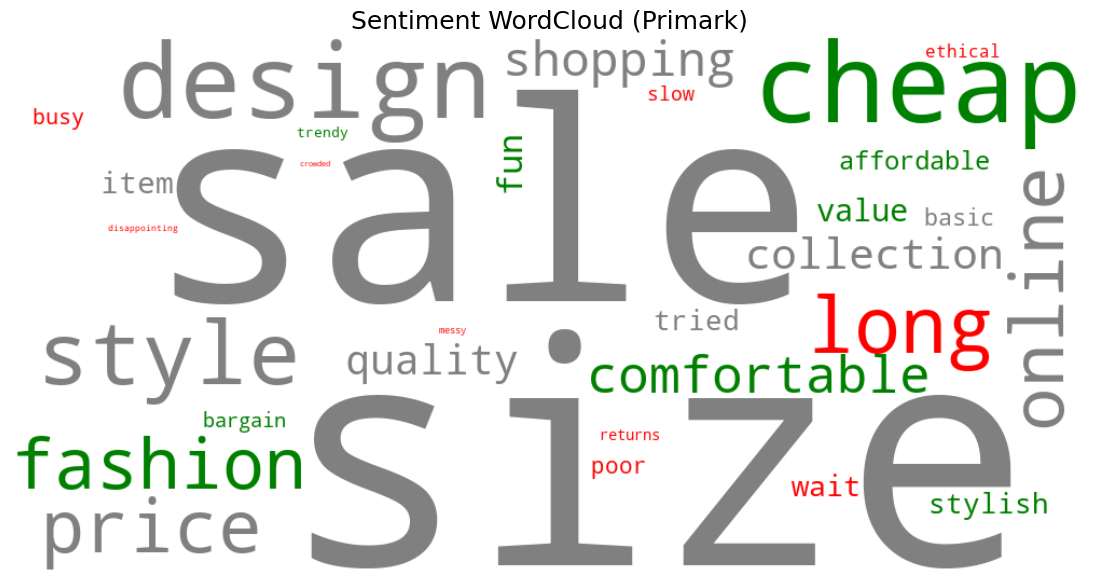

In [113]:
# Count word frequencies by sentiment
df_term_freq = df_labeled_filtered.groupBy("word", "sentiment").count().withColumnRenamed("count", "term_frequency")
df_term_freq.show()

# Convert Spark DataFrame to Pandas and filter out 'other' sentiments
df_all = df_term_freq.toPandas()
df_all = df_all[df_all["sentiment"] != "other"]  # Optional, since you already filtered earlier

# Create dictionaries for word frequency and sentiment
word_freq = dict(zip(df_all["word"], df_all["term_frequency"]))
word_sentiment = dict(zip(df_all["word"], df_all["sentiment"]))

# Define color function for WordCloud
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    sentiment = word_sentiment.get(word, "other")
    if sentiment == "positive":
        return "green"
    elif sentiment == "negative":
        return "red"
    elif sentiment == "neutral":
        return "gray"
    else:
        return "black"  # fallback

# Generate and display the WordCloud
wc = WordCloud(width=1000, height=500, background_color="white").generate_from_frequencies(word_freq)

plt.figure(figsize=(14, 7))
plt.imshow(wc.recolor(color_func=color_func, random_state=3), interpolation="bilinear")
plt.axis("off")
plt.title("Sentiment WordCloud (Primark)", fontsize=18)
plt.show()

Initial sentiment tagging was based on a limited and intuitive set of words. However, visualizing word frequencies in context revealed that several words were overly generic, sentiment-neutral, or misclassified. Recategorization and expanding the sentiment lexicon will address these gaps enables more reliable downstream analysis

In [125]:
gc.collect()

226

## Sentiment Word Categorization - Revision

| Positive        | Negative         | Neutral        |
|-----------------|------------------|----------------|
| affordable      | poor             | basic          |
| fashion         | rude             | refund         |
| bargain         | return           | ordered        |
| value           | queue            | delivered      |
| trendy          | dirty            | wearing        |
| comfortable     | unhelpful        | received       |
| stylish         | broken           | bought         |
| fun             | damaged          | purchase       |
| cute            | overpriced       | available      |
| gorgeous        | unethical        | fit            |
| fashionable     | waste            | style          |
| chic            | disgusting       | shipping       |
| comfy           | disrespectful    | item           |
| flattering      | frustrated       | instore        |
| durable         | incompetent      | online         |
| beautiful       | unprofessional   | collection     |
| unique          | slow             | stock          |
| musthave        | wait             | tried          |
| soft            | delay            | checkout       |
| vibrant         | messy            | browsing       |
| breathable      | crowded          | following      |
| versatile       | disappointing    | tagging        |
| luxurious       | returns          | mentioned      |
| fast            | ethical          | posted         |
| helpful         | busy             | shared         |
| easy            |                  | cart           |
| excellent       |                  | shipped        |
| smooth          |                  | tracking       |
| reliable        |                  | added          |
| obsessed        |                  | viewed         |
| recommend       |                  | selected       |
| satisfied       |                  | listed         |
| thrilled        |                  | quality        |
| responsive      |                  | cheap          |
| generous        |                  |                |
| pleasant        |                  |                |
| seamless        |                  |                |


In [126]:
# Tokenize text to get a column 'word'
df_words = df_new.select(explode(split(lower(col("content")), "\\s+")).alias("word"))

In [127]:
df_labeled_revised = spark.sql("""
    SELECT *,
      CASE 
        WHEN word IN (
            'affordable', 'cheap', 'fashion', 'bargain', 'value', 'trendy',
            'comfortable', 'stylish', 'fun', 'cute', 'gorgeous', 'fashionable',
            'chic', 'comfy', 'flattering', 'durable', 'beautiful',
            'unique', 'musthave', 'soft', 'vibrant', 'breathable', 'versatile',
            'luxurious', 'fast', 'helpful', 'easy', 'excellent', 'smooth',
            'reliable', 'obsessed', 'recommend', 'satisfied', 'thrilled',
            'responsive', 'generous', 'pleasant', 'seamless'
        ) THEN 'positive'
        WHEN word IN (
            'poor', 'rude', 'return', 'queue', 'dirty', 'unhelpful', 'broken',
            'damaged', 'overpriced', 'unethical', 'waste', 'disgusting',
            'disrespectful', 'frustrated', 'incompetent', 'unprofessional',
            'slow', 'wait', 'delay', 'messy', 'crowded', 'disappointing',
            'returns', 'ethical', 'busy'
        ) THEN 'negative'
        WHEN word IN (
            'basic', 'refund', 'ordered', 'delivered',
            'wearing', 'received', 'bought', 'purchase', 'available',
            'fit', 'style', 'shipping', 'item',
            'instore', 'online', 'collection', 'stock', 'tried',
            'checkout', 'browsing', 'following', 'tagging', 'mentioned', 'posted',
            'shared', 'cart', 'shipped', 'tracking', 'added',
            'viewed', 'selected', 'listed', 'quality'
        ) THEN 'neutral'
        ELSE 'other'
      END AS sentiment
    FROM word_cloud
""")

In [128]:
# Filter out only words with labeled sentiment (exclude 'other')
df_labeled_filtered_revised = df_labeled_revised.filter("sentiment != 'other'")
df_labeled_filtered_revised.show(20,truncate=False)

+----------+---------+
|word      |sentiment|
+----------+---------+
|collection|neutral  |
|style     |neutral  |
|cheap     |positive |
|slow      |negative |
|online    |neutral  |
|breathable|positive |
|online    |neutral  |
|collection|neutral  |
|collection|neutral  |
|stock     |neutral  |
|slow      |negative |
|cart      |neutral  |
|cart      |neutral  |
|cart      |neutral  |
|cheap     |positive |
|cart      |neutral  |
|cheap     |positive |
|stock     |neutral  |
|cart      |neutral  |
|soft      |positive |
+----------+---------+
only showing top 20 rows



+----------+---------+--------------+
|      word|sentiment|term_frequency|
+----------+---------+--------------+
|      item|  neutral|           250|
|     queue| negative|            30|
|   ethical| negative|            85|
|disgusting| negative|            18|
|       fit|  neutral|           288|
| satisfied| positive|            16|
|   vibrant| positive|            37|
|  gorgeous| positive|           438|
|     tried|  neutral|           222|
|   wearing|  neutral|           418|
|    shared|  neutral|            76|
|   fashion| positive|           990|
|     basic|  neutral|           160|
|   damaged| negative|            25|
|      soft| positive|           371|
|  seamless| positive|            29|
|    refund|  neutral|            12|
|      slow| negative|           102|
|   helpful| positive|            53|
|   returns| negative|            69|
+----------+---------+--------------+
only showing top 20 rows



<Figure size 1400x700 with 0 Axes>

(np.float64(-0.5), np.float64(999.5), np.float64(499.5), np.float64(-0.5))

Text(0.5, 1.0, 'Sentiment WordCloud (Primark - UK)')

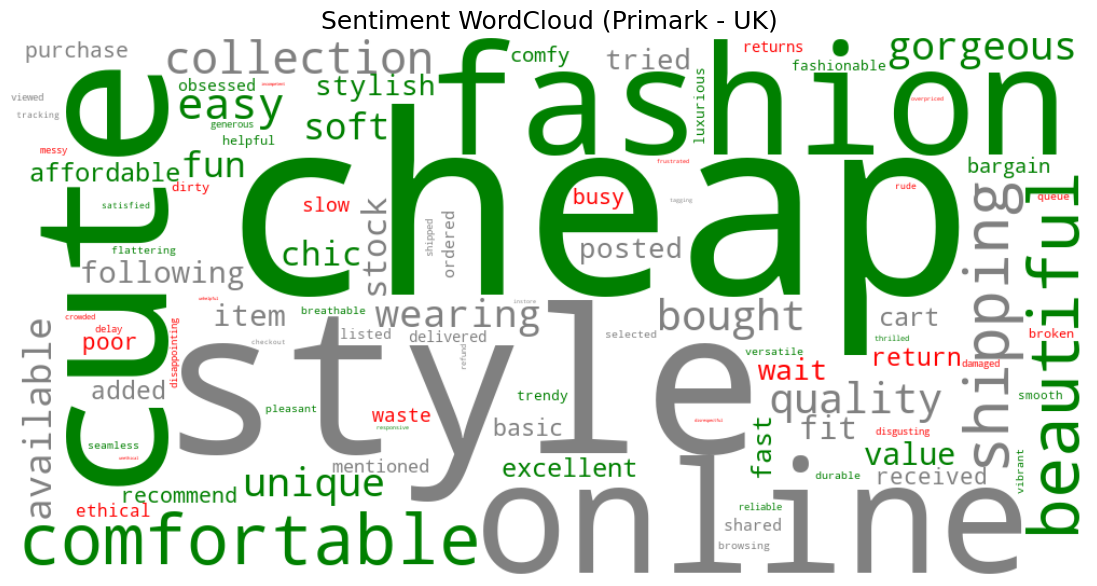

In [129]:
# Count word frequencies by sentiment
df_term_freq_revised = df_labeled_filtered_revised.groupBy("word", "sentiment").count().withColumnRenamed("count", "term_frequency")
df_term_freq_revised.show()

# Convert Spark DataFrame to Pandas and filter out 'other' sentiments
df_all = df_term_freq_revised.toPandas()
df_all = df_all[df_all["sentiment"] != "other"]  # Optional, since you already filtered earlier

# Create dictionaries for word frequency and sentiment
word_freq = dict(zip(df_all["word"], df_all["term_frequency"]))
word_sentiment = dict(zip(df_all["word"], df_all["sentiment"]))

# Define color function for WordCloud
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    sentiment = word_sentiment.get(word, "other")
    if sentiment == "positive":
        return "green"
    elif sentiment == "negative":
        return "red"
    elif sentiment == "neutral":
        return "gray"
    else:
        return "black"  # fallback

# Generate and display the WordCloud
wc = WordCloud(width=1000, height=500, background_color="white").generate_from_frequencies(word_freq)

plt.figure(figsize=(14, 7))
plt.imshow(wc.recolor(color_func=color_func, random_state=3), interpolation="bilinear")
plt.axis("off")
plt.title("Sentiment WordCloud (Primark - UK)", fontsize=18)
plt.show()

In [130]:
# Assign sentiment score only for known labels
df_scored = df_labeled.withColumn(
    "sentiment_score",
    when(col("sentiment") == "positive", 1)
    .when(col("sentiment") == "neutral", 0)
    .when(col("sentiment") == "negative", -1)
)

# Filter only labeled sentiment (exclude 'other' or nulls)
df_filtered = df_scored.filter(col("sentiment").isin("positive", "neutral", "negative"))

# Count total rows (only labeled ones)
total_words = df_filtered.count()

# Count each sentiment type
sentiment_counts = df_filtered.groupBy("sentiment").count().collect()

# Build summary rows with percentages
summary_rows = []
for row in sentiment_counts:
    sentiment = row["sentiment"]
    count = row["count"]
    percent = (count / total_words) * 100
    summary_rows.append(Row(sentiment=sentiment, count=count, percent=round(percent, 2)))

# Create and show summary table
df_summary = spark.createDataFrame(summary_rows)
df_summary.orderBy("sentiment").show(truncate=False)

# Calculate and print overall sentiment score
overall_sentiment = df_filtered.groupBy().sum("sentiment_score").collect()[0][0]
print(f"\nOverall sentiment score: {overall_sentiment}/{total_words} ({(overall_sentiment / total_words) * 100:.2f}%)")


+---------+-----+-------+
|sentiment|count|percent|
+---------+-----+-------+
|negative |1946 |9.25   |
|neutral  |13644|64.85  |
|positive |5449 |25.9   |
+---------+-----+-------+



[Stage 152:============================>                            (1 + 1) / 2]


Overall sentiment score: 3503/21039 (16.65%)


In [131]:
df_new.show()

+--------------------+--------------------+-------------------+---------------+-----------------+--------------------+----+
|             content|                 url|          timestamp|           dump|          segment|          image_urls|year|
+--------------------+--------------------+-------------------+---------------+-----------------+--------------------+----+
|- pretty petunia ...|https://drupalthe...|2019-12-05 17:20:47|CC-MAIN-2019-51|  1575540481281.1|                  []|2019|
|\nRegular Industr...|https://sctimes.i...|2019-12-05 18:35:10|CC-MAIN-2019-51|  1575540481281.1|                  []|2019|
|Sitemap Gallery L...|http://eddyindia....|2019-12-05 16:53:03|CC-MAIN-2019-51|  1575540481281.1|                  []|2019|
|Top - Primark\nJe...|http://www.ellen-...|2019-12-05 17:06:45|CC-MAIN-2019-51|  1575540481281.1|                  []|2019|
|I can't believe t...|https://www.burka...|2019-12-05 17:53:30|CC-MAIN-2019-51|  1575540481281.1|                  []|2019|
|HUGE ap

Improving semantic accuracy and capturing brand-specific tones enables more meaningful user feedback mining. However, the reliance on manual tagging remains a major limitation, introducing inconsistency and reducing the reliability of sentiment interpretation.

In [132]:
gc.collect()

317

## 4.4 Feature Engineering

### Create temporary view

In [8]:
df_new.createOrReplaceTempView("primark_filtered")

### Date and Time

In [9]:
# Remove redundant year extract during the EDA process
df_new = df_new.drop("year")

In [10]:
df_updated = spark.sql("""
    SELECT *,
           MONTH(TO_TIMESTAMP(timestamp)) AS month,
           DAY(TO_TIMESTAMP(timestamp)) AS day,
           DATE(TO_TIMESTAMP(timestamp)) AS full_date,
           DATE_FORMAT(TO_TIMESTAMP(timestamp), 'HH:mm:ss') AS time
    FROM primark_filtered
""")

df_updated.show()

+--------------------+--------------------+-------------------+---------------+-----------------+--------------------+----+-----+---+----------+--------+
|             content|                 url|          timestamp|           dump|          segment|          image_urls|year|month|day| full_date|    time|
+--------------------+--------------------+-------------------+---------------+-----------------+--------------------+----+-----+---+----------+--------+
|- pretty petunia ...|https://drupalthe...|2019-12-05 17:20:47|CC-MAIN-2019-51|  1575540481281.1|                  []|2019|   12|  5|2019-12-05|17:20:47|
|\nRegular Industr...|https://sctimes.i...|2019-12-05 18:35:10|CC-MAIN-2019-51|  1575540481281.1|                  []|2019|   12|  5|2019-12-05|18:35:10|
|Sitemap Gallery L...|http://eddyindia....|2019-12-05 16:53:03|CC-MAIN-2019-51|  1575540481281.1|                  []|2019|   12|  5|2019-12-05|16:53:03|
|Top - Primark\nJe...|http://www.ellen-...|2019-12-05 17:06:45|CC-MAIN-2019-

### URLs structure separtion

URLs contain valuable structural information that can be leveraged for analysis. By decomposing the `url` column into meaningful components, we can extract features that help identify content type, intent, or behavior patterns.

The table below summarizes the logic used to derive structured features from the `url` field:

| Feature Name        | Description                                                                | Logic / Pattern                                                             |
|---------------------|----------------------------------------------------------------------------|------------------------------------------------------------------------------|
| `url_host`          | Extracts the host (domain and subdomain) from the URL                      | `regexp_extract("url", r"https?://([^/]+)", 1)`                              |
| `url_tld`           | Extracts the top-level domain (e.g., `example.com`, `gov.uk`)              | `regexp_extract("url", r"https?://[^/]+\.?([^\.]+\.\w{2,})", 1)`             |
| `url_domain`        | Extracts base domain without subdomains                                    | `regexp_extract("url", r"https?://(?:[^/]+\.)?([^\.]+\.\w+)", 1)`           |
| `protocol`          | Extracts the protocol (HTTP or HTTPS)                                      | `regexp_extract("url", r"(https?)://", 1)`                                   |
| `is_https`          | Boolean flag indicating whether the protocol is HTTPS                      | `(protocol == "https").cast("boolean")`                                      |
| `url_path`          | Extracts the path from the URL                                             | `regexp_extract("url", r"https?://[^/]+(/[^?#]*)", 1)`                       |
| `path_depth`        | Number of segments in the URL path                                         | `size(split(url_path, "/"))`                                                 |
| `path_has_number`   | Boolean indicating if path includes numeric patterns (e.g., IDs)           | `(regexp_extract("url", r"/(\d{2,})", 1) != "").cast("boolean")`             |
| `has_ugc_keyword`   | Flag for user-generated content (UGC) keywords in path (e.g., blog, post)  | `lower(col("url")).rlike(r"/(user|blog|profile|forum|comment|post|thread)/")` |
| `has_query_params`  | Boolean flag for presence of query parameters (`?`)                        | `instr("url", "?") > 0`                                                      |
| `has_fragment`      | Boolean flag for presence of a fragment (`#`)                              | `instr("url", "#") > 0`                                                      |


In [11]:
df_urls = df_updated.select(
    "url",
    
    # host / domain info
    regexp_extract("url", r"https?://([^/]+)", 1).alias("url_host"),
    regexp_extract("url", r"https?://[^/]+\.?([^\.]+\.\w{2,})", 1).alias("url_tld"),
    regexp_extract("url", r"https?://(?:[^/]+\.)?([^\.]+\.\w+)", 1).alias("url_domain"),

    # protocol
    regexp_extract("url", r"(https?)://", 1).alias("protocol"),
    
    # is_https (binary feature)
    (regexp_extract("url", r"(https?)://", 1) == "https").cast("boolean").alias("is_https"),

    # path
    regexp_extract("url", r"https?://[^/]+(/[^?#]*)", 1).alias("url_path"),
    
    # path depth (number of segments)
    size(split(regexp_extract("url", r"https?://[^/]+(/[^?#]*)", 1), "/")).alias("path_depth"),

    # path has numeric
    (regexp_extract("url", r"/(\d{2,})", 1) != "").cast("boolean").alias("path_has_number"),

    # path has UGC keywords (like /user/ or /blog/)
    (lower(col("url")).rlike(r"/(user|blog|profile|forum|comment|post|thread)/")).alias("has_ugc_keyword"),

    # has query parameters
    (instr("url", "?") > 0).alias("has_query_params"),

    # has fragment (#section)
    (instr("url", "#") > 0).alias("has_fragment")
)


df_urls.show(10)

+--------------------+--------------------+--------------------+--------------------+--------+--------+--------------------+----------+---------------+---------------+----------------+------------+
|                 url|            url_host|             url_tld|          url_domain|protocol|is_https|            url_path|path_depth|path_has_number|has_ugc_keyword|has_query_params|has_fragment|
+--------------------+--------------------+--------------------+--------------------+--------+--------+--------------------+----------+---------------+---------------+----------------+------------+
|https://drupalthe...|drupalthemes.website|           s.website|drupalthemes.website|   https|    true|              /mw/p/|         4|          false|          false|           false|       false|
|https://sctimes.i...|          sctimes.io|                s.io|          sctimes.io|   https|    true|/news/article/7/6626|         5|           true|          false|           false|       false|
|http://ed

In [12]:
# Filter only rows with UGC-like keywords in URL path
ugc_df = df_urls.filter(col("has_ugc_keyword") == True)

# Show the filtered result
ugc_df.show()
ugc_df.count()

+--------------------+--------------------+--------------------+--------------------+--------+--------+--------------------+----------+---------------+---------------+----------------+------------+
|                 url|            url_host|             url_tld|          url_domain|protocol|is_https|            url_path|path_depth|path_has_number|has_ugc_keyword|has_query_params|has_fragment|
+--------------------+--------------------+--------------------+--------------------+--------+--------+--------------------+----------+---------------+---------------+----------------+------------+
|https://www.liber...|www.libertyliving...|                o.uk|               co.uk|   https|    true|/media/blog/archi...|         6|           true|           true|           false|       false|
|https://www.husky...|www.husky-owners.com|               s.com|    husky-owners.com|   https|    true|/forum/43-bargain...|         4|           true|           true|           false|       false|
|http://gu

40

In [13]:
# Updated to dataframe
df_updated = df_updated.select(
    "*",
    
    # host / domain info
    regexp_extract("url", r"https?://([^/]+)", 1).alias("url_host"),
    regexp_extract("url", r"https?://(?:[^/]+\.)?([^\.]+\.\w+)", 1).alias("url_domain"),

    # full tld
    concat_ws(
        ".",
        split(regexp_extract("url", r"https?://([^/]+)", 1), r"\.").getItem(-2),
        split(regexp_extract("url", r"https?://([^/]+)", 1), r"\.").getItem(-1)
    ).alias("url_tld"),

    # protocol
    regexp_extract("url", r"(https?)://", 1).alias("protocol"),
    
    # is_https (binary feature)
    (regexp_extract("url", r"(https?)://", 1) == "https").cast("boolean").alias("is_https"),

    # path
    regexp_extract("url", r"https?://[^/]+(/[^?#]*)", 1).alias("url_path"),
    
    # path depth (number of segments)
    size(split(regexp_extract("url", r"https?://[^/]+(/[^?#]*)", 1), "/")).alias("path_depth"),

    # path has numeric
    (regexp_extract("url", r"/(\d{2,})", 1) != "").cast("boolean").alias("path_has_number"),

    # path has UGC keywords (like /user/ or /blog/)
    (lower(col("url")).rlike(r"/(user|blog|profile|forum|comment|post|thread)/")).alias("has_ugc_keyword"),

    # has query parameters
    (instr("url", "?") > 0).alias("has_query_params"),

    # has fragment (#section)
    (instr("url", "#") > 0).alias("has_fragment")
)

df_updated.show(10)

+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+-----+---+----------+--------+--------------------+--------------------+-------+--------+--------+--------------------+----------+---------------+---------------+----------------+------------+
|             content|                 url|          timestamp|           dump|        segment|          image_urls|year|month|day| full_date|    time|            url_host|          url_domain|url_tld|protocol|is_https|            url_path|path_depth|path_has_number|has_ugc_keyword|has_query_params|has_fragment|
+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+-----+---+----------+--------+--------------------+--------------------+-------+--------+--------+--------------------+----------+---------------+---------------+----------------+------------+
|- pretty petunia ...|https://drupalthe...|2019-12-05 17:2

### Page length (by number of words)

In [14]:
df_updated = df_updated.withColumn(
    "page_length",
    size(split(col("content"), r"\s+"))  # count of words based on whitespace
)

In [15]:
df_updated.show(10)

+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+-----+---+----------+--------+--------------------+--------------------+-------+--------+--------+--------------------+----------+---------------+---------------+----------------+------------+-----------+
|             content|                 url|          timestamp|           dump|        segment|          image_urls|year|month|day| full_date|    time|            url_host|          url_domain|url_tld|protocol|is_https|            url_path|path_depth|path_has_number|has_ugc_keyword|has_query_params|has_fragment|page_length|
+--------------------+--------------------+-------------------+---------------+---------------+--------------------+----+-----+---+----------+--------+--------------------+--------------------+-------+--------+--------+--------------------+----------+---------------+---------------+----------------+------------+-----------+
|- pretty petunia ...|

### Has image (from image_urls)

In [16]:
df_updated = df_updated.withColumn(
    "has_image",
    when((col("image_urls").isNotNull()) & (size(col("image_urls")) > 0), True).otherwise(False)
)

# Preview only 
df_updated.select("url", "image_urls", "has_image").show()

+--------------------+--------------------+---------+
|                 url|          image_urls|has_image|
+--------------------+--------------------+---------+
|https://drupalthe...|                  []|    false|
|https://sctimes.i...|                  []|    false|
|http://eddyindia....|                  []|    false|
|http://www.ellen-...|                  []|    false|
|https://www.burka...|                  []|    false|
|http://www.little...|                  []|    false|
|https://chrissjon...|                  []|    false|
|http://www.bizstr...|[[https://n.nords...|     true|
|https://www.share...|[[/971029/globala...|     true|
|http://www.fancyf...|                  []|    false|
|http://www.smugpu...|[[http://1.bp.blo...|     true|
|http://www.be-a-g...|                  []|    false|
|http://www.produc...|[[/img/choose-pho...|     true|
|http://unfortunat...|                  []|    false|
|http://www.be-a-g...|                  []|    false|
|http://stylelovin...|      

### Adding brand_name

Attempts to Using Spark jobs to compute `mention_count` per document is impractical due to reliance on `monotonically_increasing_id()`, which:

- Does not guarantee consistent ID assignment after operations like `.filter()`, `.sort()`, or `.sample()`
- Makes merging results back to the original dataset unreliable
- Lacks a stable join key (e.g., `url` or true `doc_id`) in word count outputs

In [17]:
df_updated = df_updated.withColumn(
    "brand_name",
    when(
        (
            (lower(col("content")).contains("primark")) |
            (lower(col("url")).contains("primark"))
        ) &
        ~((lower(col("content")).contains("h&m")) | (lower(col("url")).contains("h&m"))) &
        ~((lower(col("content")).contains("zara")) | (lower(col("url")).contains("zara"))),
        "Primark"
    ).when(
        (
            (lower(col("content")).contains("h&m")) |
            (lower(col("url")).contains("h&m"))
        ) &
        ~((lower(col("content")).contains("primark")) | (lower(col("url")).contains("primark"))) &
        ~((lower(col("content")).contains("zara")) | (lower(col("url")).contains("zara"))),
        "H&M"
    ).when(
        (
            (lower(col("content")).contains("zara")) |
            (lower(col("url")).contains("zara"))
        ) &
        ~((lower(col("content")).contains("primark")) | (lower(col("url")).contains("primark"))) &
        ~((lower(col("content")).contains("h&m")) | (lower(col("url")).contains("h&m"))),
        "Zara"
    ).otherwise(None)
)

df_updated.show()

+--------------------+--------------------+-------------------+---------------+-----------------+--------------------+----+-----+---+----------+--------+--------------------+--------------------+-------+--------+--------+--------------------+----------+---------------+---------------+----------------+------------+-----------+---------+----------+
|             content|                 url|          timestamp|           dump|          segment|          image_urls|year|month|day| full_date|    time|            url_host|          url_domain|url_tld|protocol|is_https|            url_path|path_depth|path_has_number|has_ugc_keyword|has_query_params|has_fragment|page_length|has_image|brand_name|
+--------------------+--------------------+-------------------+---------------+-----------------+--------------------+----+-----+---+----------+--------+--------------------+--------------------+-------+--------+--------+--------------------+----------+---------------+---------------+----------------+

### mention

Boolean flag if the brand appears. Filters rows to train only on relevant mentions.

In [18]:
brand = "Primark"
df_updated = df_updated.withColumn("brand_name", lit(brand))

In [19]:
# .withColumn("mentioned", ...) using instr (string contains)
df_updated = df_updated.withColumn(
    "mentioned",
    instr(lower(col("content")), brand.lower()) > 0
)

### mention_count

In [20]:
# mention_count from brand_name columns
df_updated = df_updated.withColumn(
    "mention_count",
    expr("size(split(lower(content), lower(brand_name))) - 1")
)

In [21]:
df_updated.show(2)

+--------------------+--------------------+-------------------+---------------+---------------+----------+----+-----+---+----------+--------+--------------------+--------------------+-------+--------+--------+--------------------+----------+---------------+---------------+----------------+------------+-----------+---------+----------+---------+-------------+
|             content|                 url|          timestamp|           dump|        segment|image_urls|year|month|day| full_date|    time|            url_host|          url_domain|url_tld|protocol|is_https|            url_path|path_depth|path_has_number|has_ugc_keyword|has_query_params|has_fragment|page_length|has_image|brand_name|mentioned|mention_count|
+--------------------+--------------------+-------------------+---------------+---------------+----------+----+-----+---+----------+--------+--------------------+--------------------+-------+--------+--------+--------------------+----------+---------------+---------------+-----

In [22]:
pd.set_option('display.max_columns', None)
pdf_updated = df_updated.toPandas()
pdf_updated.head()

,content,url,timestamp,dump,segment,image_urls,year,month,day,full_date,time,url_host,url_domain,url_tld,protocol,is_https,url_path,path_depth,path_has_number,has_ugc_keyword,has_query_params,has_fragment,page_length,has_image,brand_name,mentioned,mention_count
0,- pretty petunia pickle bottom intermix\n- pla...,https://drupalthemes.website/mw/p/,2019-12-05 17:20:47,CC-MAIN-2019-51,1575540481281.1,[],2019,12,5,2019-12-05,17:20:47,drupalthemes.website,drupalthemes.website,,https,True,/mw/p/,4,False,False,False,False,35057,False,Primark,True,1
1,"\nRegular Industry Development Updates, Opinio...",https://sctimes.io/news/article/7/6626,2019-12-05 18:35:10,CC-MAIN-2019-51,1575540481281.1,[],2019,12,5,2019-12-05,18:35:10,sctimes.io,sctimes.io,,https,True,/news/article/7/6626,5,True,False,False,False,912,False,Primark,True,1
2,Sitemap Gallery L little 8 in 1 playground cli...,http://eddyindia.com/vm/l/,2019-12-05 16:53:03,CC-MAIN-2019-51,1575540481281.1,[],2019,12,5,2019-12-05,16:53:03,eddyindia.com,eddyindia.com,,http,False,/vm/l/,4,False,False,False,False,16248,False,Primark,True,2
3,Top - Primark\nJeans - ℅ American Eagle Outfit...,http://www.ellen-atlanta.com/2015/03/aeodenimd...,2019-12-05 17:06:45,CC-MAIN-2019-51,1575540481281.1,[],2019,12,5,2019-12-05,17:06:45,www.ellen-atlanta.com,com/2015/03/aeodenimdiaries-part-1.html,,http,False,/2015/03/aeodenimdiaries-part-1.html,4,True,False,False,False,286,False,Primark,True,2
4,I can't believe the sun is shining and I'm in ...,https://www.burkatron.com/2012/08/what-i-wore-...,2019-12-05 17:53:30,CC-MAIN-2019-51,1575540481281.1,[],2019,12,5,2019-12-05,17:53:30,www.burkatron.com,com/2012/08/what-i-wore-today-dahlia-double-co...,,https,True,/2012/08/what-i-wore-today-dahlia-double-colla...,4,True,False,True,False,268,False,Primark,True,1


In [23]:
pdf_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360 entries, 0 to 1359
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   content           1360 non-null   object        
 1   url               1360 non-null   object        
 2   timestamp         1360 non-null   datetime64[ns]
 3   dump              1360 non-null   object        
 4   segment           1360 non-null   object        
 5   image_urls        1360 non-null   object        
 6   year              1360 non-null   int32         
 7   month             1360 non-null   int32         
 8   day               1360 non-null   int32         
 9   full_date         1360 non-null   object        
 10  time              1360 non-null   object        
 11  url_host          1360 non-null   object        
 12  url_domain        1360 non-null   object        
 13  url_tld           1360 non-null   object        
 14  protocol          1360 n

### Remove irrelevant columns & Reorder

In [24]:
# Define the required columns in the desired order
final_columns = [
    "brand_name", "mentioned", "mention_count", 
    "url", "url_host", "url_domain",
    "path_has_number", "has_query_params",
    "content", "page_length", "has_ugc_keyword",
    "day", "month", "year", "full_date", "time"
]

# Drop and reorder Spark DataFrame
df_updated = df_updated.select(*final_columns)
df_updated.show(2)

+----------+---------+-------------+--------------------+--------------------+--------------------+---------------+----------------+--------------------+-----------+---------------+---+-----+----+----------+--------+
|brand_name|mentioned|mention_count|                 url|            url_host|          url_domain|path_has_number|has_query_params|             content|page_length|has_ugc_keyword|day|month|year| full_date|    time|
+----------+---------+-------------+--------------------+--------------------+--------------------+---------------+----------------+--------------------+-----------+---------------+---+-----+----+----------+--------+
|   Primark|     true|            1|https://drupalthe...|drupalthemes.website|drupalthemes.website|          false|           false|- pretty petunia ...|      35057|          false|  5|   12|2019|2019-12-05|17:20:47|
|   Primark|     true|            1|https://sctimes.i...|          sctimes.io|          sctimes.io|           true|           false|

In [25]:
# Convert to Pandas DataFrame
pdf_updated = df_updated.toPandas()

# Reorder columns in the pandas dataframe
pdf_updated = pdf_updated[final_columns]
pdf_updated

,brand_name,mentioned,mention_count,url,url_host,url_domain,path_has_number,has_query_params,content,page_length,has_ugc_keyword,day,month,year,full_date,time
0,Primark,True,1,https://drupalthemes.website/mw/p/,drupalthemes.website,drupalthemes.website,False,False,- pretty petunia pickle bottom intermix\n- pla...,35057,False,5,12,2019,2019-12-05,17:20:47
1,Primark,True,1,https://sctimes.io/news/article/7/6626,sctimes.io,sctimes.io,True,False,"\nRegular Industry Development Updates, Opinio...",912,False,5,12,2019,2019-12-05,18:35:10
2,Primark,True,2,http://eddyindia.com/vm/l/,eddyindia.com,eddyindia.com,False,False,Sitemap Gallery L little 8 in 1 playground cli...,16248,False,5,12,2019,2019-12-05,16:53:03
3,Primark,True,2,http://www.ellen-atlanta.com/2015/03/aeodenimd...,www.ellen-atlanta.com,com/2015/03/aeodenimdiaries-part-1.html,True,False,Top - Primark\nJeans - ℅ American Eagle Outfit...,286,False,5,12,2019,2019-12-05,17:06:45
4,Primark,True,1,https://www.burkatron.com/2012/08/what-i-wore-...,www.burkatron.com,com/2012/08/what-i-wore-today-dahlia-double-co...,True,True,I can't believe the sun is shining and I'm in ...,268,False,5,12,2019,2019-12-05,17:53:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,Primark,True,1,http://www.allopeningtimes.co.uk/tesco-opening...,www.allopeningtimes.co.uk,uk/tesco-opening-times/tesco-poole-131-139-fer...,False,False,"Tesco, Poole opening hours\nPoole Fernside Rd ...",519,False,23,3,2017,2017-03-23,02:10:13
1356,Primark,True,2,http://www.glitterandgrimes.com/2013_03_01_arc...,www.glitterandgrimes.com,com/2013_03_01_archive.html,True,False,"Punk Tee - Primark,\nBlack Safia Velvet Tulip ...",202,False,23,3,2017,2017-03-23,02:10:19
1357,Primark,True,1,http://www.businessinsider.com/britain-record-...,www.businessinsider.com,businessinsider.com,False,False,Adele\nsold rather a few physical records last...,323,False,23,3,2017,2017-03-23,03:40:48
1358,Primark,True,1,https://rupahuq.wordpress.com/2007/09/03/no-sw...,rupahuq.wordpress.com,wordpress.com,True,False,Everyone likes a bargain but the fact that the...,1094,False,23,3,2017,2017-03-23,02:10:26


### Saved as new parquet files (Checkpoint)

**Note:** The code block below has been intentionally hidden to prevent unintentional multiple downloads of the dataset. This is a best practice to avoid redundant operations that may consume unnecessary resources or lead to duplicate file writes.
Save cleaned data as a single files

In [27]:
# Save cleaned data as a single files
filtered_path = "filtered_data/initial_primark_2014_2022.parquet"
df_updated.coalesce(1).write.mode("overwrite").option("compression", "snappy").parquet(filtered_path)

In [28]:
gc.collect()

546

In [29]:
gc.collect()

0

### External Dataset Commbination Trial

Enrich data with google trends

In [44]:
# Full path to the actual parquet file (not the folder)
initial_path = "filtered_data/initial_primark_2014_2022.parquet/part-00000-08b339c1-873d-4302-92d7-da6e25a5d4dc-c000.snappy.parquet"

In [45]:
# Read the single Parquet file
df_update = spark.read.parquet(initial_path)

### Create temporary view

In [46]:
df_update.createOrReplaceTempView("external")

In [47]:
df_updated.show(3)

+----------+---------+-------------+--------------------+--------------------+--------------------+---------------+----------------+--------------------+-----------+---------------+---+-----+----+----------+--------+
|brand_name|mentioned|mention_count|                 url|            url_host|          url_domain|path_has_number|has_query_params|             content|page_length|has_ugc_keyword|day|month|year| full_date|    time|
+----------+---------+-------------+--------------------+--------------------+--------------------+---------------+----------------+--------------------+-----------+---------------+---+-----+----+----------+--------+
|   Primark|     true|            1|https://drupalthe...|drupalthemes.website|drupalthemes.website|          false|           false|- pretty petunia ...|      35057|          false|  5|   12|2019|2019-12-05|17:20:47|
|   Primark|     true|            1|https://sctimes.i...|          sctimes.io|          sctimes.io|           true|           false|

In [50]:
current_directory = os.getcwd()

In [51]:
# File paths
years = list(range(2014, 2023))
paths = [f"{current_directory}/google-trends/{y}-multiTimeline.csv" for y in years]

gt_combined = None

for path in paths:
    # Read as text and skip first 2 rows
    raw_rdd = spark.read.text(path).rdd.zipWithIndex().filter(lambda x: x[1] >= 2).map(lambda x: x[0][0])
    raw_df = spark.createDataFrame(raw_rdd.map(lambda line: line.split(','))).toDF("Week", "google_trends_score")

    # Transform
    df = raw_df.withColumn("Week", to_date("Week", "yyyy-MM-dd")) \
               .withColumn("google_trends_score", col("google_trends_score").cast("double")) \
               .withColumn("year", year("Week")) \
               .withColumn("week", weekofyear("Week"))

    gt_combined = df if gt_combined is None else gt_combined.unionByName(df)

# Join with your existing df
df_updated = df_updated.withColumn("week", weekofyear("full_date"))
df_joined = df_updated.join(
    gt_combined.select("year", "week", "google_trends_score"),
    on=["year", "week"],
    how="left"
)

df_final.show()

+----+----+----------+---------+-------------+--------------------+--------------------+--------------------+---------------+----------------+--------------------+-----------+---------------+---+-----+----------+--------+-------------------+
|year|week|brand_name|mentioned|mention_count|                 url|            url_host|          url_domain|path_has_number|has_query_params|             content|page_length|has_ugc_keyword|day|month| full_date|    time|google_trends_score|
+----+----+----------+---------+-------------+--------------------+--------------------+--------------------+---------------+----------------+--------------------+-----------+---------------+---+-----+----------+--------+-------------------+
|2014|  51|   Primark|     true|            1|http://www.travel...|   www.travelpod.com|com/hotel/Motel-2...|          false|           false|Motel 24h Berlin\...|        432|          false| 18|   12|2014-12-18|10:15:17|               80.0|
|2014|  51|   Primark|     true|

In [52]:
pd.set_option('display.max_columns', None)
pdf_final = df_final.toPandas()
pdf_final.head()

,year,week,brand_name,mentioned,mention_count,url,url_host,url_domain,path_has_number,has_query_params,content,page_length,has_ugc_keyword,day,month,full_date,time,google_trends_score
0,2018,38,Primark,True,1,https://philippapearne.com/about-2/,philippapearne.com,philippapearne.com,False,False,Previously Beauty Editor of Glamour UK for fiv...,147,False,18,9,2018-09-18,23:10:56,NaN
1,2018,38,Primark,True,1,https://pennyxxlane.com/hm-checked-dress/,pennyxxlane.com,pennyxxlane.com,False,False,At the beginning of the month I went out into ...,143,False,18,9,2018-09-18,23:01:31,NaN
2,2018,38,Primark,True,3,http://www.bethanyemerton.com/2013/11/,www.bethanyemerton.com,bethanyemerton.com,True,False,It's come to my attention that misplacing bare...,1089,False,18,9,2018-09-18,23:10:36,NaN
3,2018,38,Primark,True,1,http://pixie-false.blogspot.com/2012/08/my-ril...,pixie-false.blogspot.com,com/2012/08/my-rilakkuma-kigu-arrived.html,True,False,Hooraaaay!!\nAfter a 6 weeks wait it finally a...,173,False,18,9,2018-09-18,23:21:48,NaN
4,2018,38,Primark,True,1,http://www.sunsondesigns.com/xmas-tree-ornament/,www.sunsondesigns.com,sunsondesigns.com,False,False,"Nov 29, 2017. Skip the store-bought decor, and...",1435,False,18,9,2018-09-18,23:04:52,NaN


In [53]:
pdf_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1730 entries, 0 to 1729
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 1730 non-null   int32  
 1   week                 1730 non-null   int32  
 2   brand_name           1730 non-null   object 
 3   mentioned            1730 non-null   bool   
 4   mention_count        1730 non-null   int32  
 5   url                  1730 non-null   object 
 6   url_host             1730 non-null   object 
 7   url_domain           1730 non-null   object 
 8   path_has_number      1730 non-null   bool   
 9   has_query_params     1730 non-null   bool   
 10  content              1730 non-null   object 
 11  page_length          1730 non-null   int32  
 12  has_ugc_keyword      1730 non-null   bool   
 13  day                  1730 non-null   int32  
 14  month                1730 non-null   int32  
 15  full_date            1730 non-null   o

While attempting to integrate Google Trends data, we encountered a limitation with Pytrends, which is an unofficial library and no longer reliably functions due to increased anti-bot protections by Google, resulting in persistent HTTP 429 errors. Alternative options such as SerpAPI exist but require paid subscriptions, and manual extraction is not scalable for larger pipelines. As a result, we decided to remove the `google_trends_score` feature from the dataset to ensure long-term maintainability and system scalability. Furthermore, the mismatched time updated is difficult to match even manual configuration (as seen, there is still null values)

In [54]:
df_final = df_final.drop("google_trends_score")

In [55]:
pdf_final = df_final.toPandas()
pdf_final.head()

,year,week,brand_name,mentioned,mention_count,url,url_host,url_domain,path_has_number,has_query_params,content,page_length,has_ugc_keyword,day,month,full_date,time
0,2018,38,Primark,True,1,https://philippapearne.com/about-2/,philippapearne.com,philippapearne.com,False,False,Previously Beauty Editor of Glamour UK for fiv...,147,False,18,9,2018-09-18,23:10:56
1,2018,38,Primark,True,1,https://pennyxxlane.com/hm-checked-dress/,pennyxxlane.com,pennyxxlane.com,False,False,At the beginning of the month I went out into ...,143,False,18,9,2018-09-18,23:01:31
2,2018,38,Primark,True,3,http://www.bethanyemerton.com/2013/11/,www.bethanyemerton.com,bethanyemerton.com,True,False,It's come to my attention that misplacing bare...,1089,False,18,9,2018-09-18,23:10:36
3,2018,38,Primark,True,1,http://pixie-false.blogspot.com/2012/08/my-ril...,pixie-false.blogspot.com,com/2012/08/my-rilakkuma-kigu-arrived.html,True,False,Hooraaaay!!\nAfter a 6 weeks wait it finally a...,173,False,18,9,2018-09-18,23:21:48
4,2018,38,Primark,True,1,http://www.sunsondesigns.com/xmas-tree-ornament/,www.sunsondesigns.com,sunsondesigns.com,False,False,"Nov 29, 2017. Skip the store-bought decor, and...",1435,False,18,9,2018-09-18,23:04:52


In [56]:
pdf_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1730 entries, 0 to 1729
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              1730 non-null   int32 
 1   week              1730 non-null   int32 
 2   brand_name        1730 non-null   object
 3   mentioned         1730 non-null   bool  
 4   mention_count     1730 non-null   int32 
 5   url               1730 non-null   object
 6   url_host          1730 non-null   object
 7   url_domain        1730 non-null   object
 8   path_has_number   1730 non-null   bool  
 9   has_query_params  1730 non-null   bool  
 10  content           1730 non-null   object
 11  page_length       1730 non-null   int32 
 12  has_ugc_keyword   1730 non-null   bool  
 13  day               1730 non-null   int32 
 14  month             1730 non-null   int32 
 15  full_date         1730 non-null   object
 16  time              1730 non-null   object
dtypes: bool(4), in

In [58]:
pd.reset_option('display.max_columns')

### Preview Dataset

In [65]:
# ReDefine the required columns in the desired order
final_columns = [
    "brand_name", "mentioned", "mention_count", 
    "url", "url_host", "url_domain",
    "path_has_number", "has_query_params",
    "content", "page_length", "has_ugc_keyword",
    "day", "month", "year", "full_date", "time"
]

# Drop and reorder Spark DataFrame
df_final = df_updated.select(*final_columns)
df_final.show(2)

+----------+---------+-------------+--------------------+--------------------+--------------------+---------------+----------------+--------------------+-----------+---------------+---+-----+----+----------+--------+
|brand_name|mentioned|mention_count|                 url|            url_host|          url_domain|path_has_number|has_query_params|             content|page_length|has_ugc_keyword|day|month|year| full_date|    time|
+----------+---------+-------------+--------------------+--------------------+--------------------+---------------+----------------+--------------------+-----------+---------------+---+-----+----+----------+--------+
|   Primark|     true|            1|https://drupalthe...|drupalthemes.website|drupalthemes.website|          false|           false|- pretty petunia ...|      35057|          false|  5|   12|2019|2019-12-05|17:20:47|
|   Primark|     true|            1|https://sctimes.i...|          sctimes.io|          sctimes.io|           true|           false|

In [66]:
df_final.show()
df_final.printSchema()

+----------+---------+-------------+--------------------+--------------------+--------------------+---------------+----------------+--------------------+-----------+---------------+---+-----+----+----------+--------+
|brand_name|mentioned|mention_count|                 url|            url_host|          url_domain|path_has_number|has_query_params|             content|page_length|has_ugc_keyword|day|month|year| full_date|    time|
+----------+---------+-------------+--------------------+--------------------+--------------------+---------------+----------------+--------------------+-----------+---------------+---+-----+----+----------+--------+
|   Primark|     true|            1|https://drupalthe...|drupalthemes.website|drupalthemes.website|          false|           false|- pretty petunia ...|      35057|          false|  5|   12|2019|2019-12-05|17:20:47|
|   Primark|     true|            1|https://sctimes.i...|          sctimes.io|          sctimes.io|           true|           false|

In [67]:
print(f"Total columns: {len(df_final.columns)}")
print("Columns:", df_final.columns)

Total columns: 16
Columns: ['brand_name', 'mentioned', 'mention_count', 'url', 'url_host', 'url_domain', 'path_has_number', 'has_query_params', 'content', 'page_length', 'has_ugc_keyword', 'day', 'month', 'year', 'full_date', 'time']


In [70]:
pdf_final = df_final.toPandas()
pdf_final.head()

,brand_name,mentioned,mention_count,url,url_host,url_domain,path_has_number,has_query_params,content,page_length,has_ugc_keyword,day,month,year,full_date,time
0,Primark,True,1,https://drupalthemes.website/mw/p/,drupalthemes.website,drupalthemes.website,False,False,- pretty petunia pickle bottom intermix\n- pla...,35057,False,5,12,2019,2019-12-05,17:20:47
1,Primark,True,1,https://sctimes.io/news/article/7/6626,sctimes.io,sctimes.io,True,False,"\nRegular Industry Development Updates, Opinio...",912,False,5,12,2019,2019-12-05,18:35:10
2,Primark,True,2,http://eddyindia.com/vm/l/,eddyindia.com,eddyindia.com,False,False,Sitemap Gallery L little 8 in 1 playground cli...,16248,False,5,12,2019,2019-12-05,16:53:03
3,Primark,True,2,http://www.ellen-atlanta.com/2015/03/aeodenimd...,www.ellen-atlanta.com,com/2015/03/aeodenimdiaries-part-1.html,True,False,Top - Primark\nJeans - ℅ American Eagle Outfit...,286,False,5,12,2019,2019-12-05,17:06:45
4,Primark,True,1,https://www.burkatron.com/2012/08/what-i-wore-...,www.burkatron.com,com/2012/08/what-i-wore-today-dahlia-double-co...,True,True,I can't believe the sun is shining and I'm in ...,268,False,5,12,2019,2019-12-05,17:53:30


## 4.5 Data Categorization

In [69]:
schema_df = spark.createDataFrame([Row(col=col, dtype=dtype) for col, dtype in df_updated.dtypes])
schema_df.show()

+----------------+-------+
|             col|  dtype|
+----------------+-------+
|      brand_name| string|
|       mentioned|boolean|
|   mention_count|    int|
|             url| string|
|        url_host| string|
|      url_domain| string|
| path_has_number|boolean|
|has_query_params|boolean|
|         content| string|
|     page_length|    int|
| has_ugc_keyword|boolean|
|             day|    int|
|           month|    int|
|            year|    int|
|       full_date|   date|
|            time| string|
+----------------+-------+



In [73]:
pdf_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360 entries, 0 to 1359
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   brand_name        1360 non-null   object
 1   mentioned         1360 non-null   bool  
 2   mention_count     1360 non-null   int32 
 3   url               1360 non-null   object
 4   url_host          1360 non-null   object
 5   url_domain        1360 non-null   object
 6   path_has_number   1360 non-null   bool  
 7   has_query_params  1360 non-null   bool  
 8   content           1360 non-null   object
 9   page_length       1360 non-null   int32 
 10  has_ugc_keyword   1360 non-null   bool  
 11  day               1360 non-null   int32 
 12  month             1360 non-null   int32 
 13  year              1360 non-null   int32 
 14  full_date         1360 non-null   object
 15  time              1360 non-null   object
dtypes: bool(4), int32(5), object(7)
memory usage: 106.4+ KB


The final dataset (`pdf_final`) contains 1,360 records across 16 columns, with no missing values in any field. However, the date and time would be recategorized 

In [76]:
# Convert full_date to datetime
pdf_final['full_date'] = pd.to_datetime(pdf_final['full_date'])

# Convert time to time format
pdf_final['time'] = pd.to_datetime(pdf_final['time'], format='%H:%M:%S').dt.time

In [77]:
pdf_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360 entries, 0 to 1359
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   brand_name        1360 non-null   object        
 1   mentioned         1360 non-null   bool          
 2   mention_count     1360 non-null   int32         
 3   url               1360 non-null   object        
 4   url_host          1360 non-null   object        
 5   url_domain        1360 non-null   object        
 6   path_has_number   1360 non-null   bool          
 7   has_query_params  1360 non-null   bool          
 8   content           1360 non-null   object        
 9   page_length       1360 non-null   int32         
 10  has_ugc_keyword   1360 non-null   bool          
 11  day               1360 non-null   int32         
 12  month             1360 non-null   int32         
 13  year              1360 non-null   int32         
 14  full_date         1360 n

In [78]:
pdf_final.head()

,brand_name,mentioned,mention_count,url,url_host,url_domain,path_has_number,has_query_params,content,page_length,has_ugc_keyword,day,month,year,full_date,time
0,Primark,True,1,https://drupalthemes.website/mw/p/,drupalthemes.website,drupalthemes.website,False,False,- pretty petunia pickle bottom intermix\n- pla...,35057,False,5,12,2019,2019-12-05,17:20:47
1,Primark,True,1,https://sctimes.io/news/article/7/6626,sctimes.io,sctimes.io,True,False,"\nRegular Industry Development Updates, Opinio...",912,False,5,12,2019,2019-12-05,18:35:10
2,Primark,True,2,http://eddyindia.com/vm/l/,eddyindia.com,eddyindia.com,False,False,Sitemap Gallery L little 8 in 1 playground cli...,16248,False,5,12,2019,2019-12-05,16:53:03
3,Primark,True,2,http://www.ellen-atlanta.com/2015/03/aeodenimd...,www.ellen-atlanta.com,com/2015/03/aeodenimdiaries-part-1.html,True,False,Top - Primark\nJeans - ℅ American Eagle Outfit...,286,False,5,12,2019,2019-12-05,17:06:45
4,Primark,True,1,https://www.burkatron.com/2012/08/what-i-wore-...,www.burkatron.com,com/2012/08/what-i-wore-today-dahlia-double-co...,True,True,I can't believe the sun is shining and I'm in ...,268,False,5,12,2019,2019-12-05,17:53:30


## 4.6 Final Dataset Dictionary

| Columns             | Explanation                                                                                                                                                   |
|---------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|
| brand_name*         | The specific brand being analyzed or tracked (e.g., “Primark”, “Zara”). Used to generate brand-specific training examples.                                   |
| mentioned           | Boolean flag if the brand appears. Filters rows to train only on relevant mentions.                                                                           |
| mention_count       | Number of times the brand is mentioned in the content.                                                                                                        |
| url                 | Full URL of the page. Acts as a unique identifier for the page.                                                                                                |
| url_host            | Subdomain (e.g., twitter.com / X.com). Assists with source credibility checks.                                                                                |
| url_domain          | Root domain (e.g., twitter.com / X.com). Helps deduplicate and rank high-authority sources.                                                                  |
| path_has_number     | Indicates if URL contains IDs (e.g., product pages). Can help isolate commercial vs editorial content.                                                        |
| has_query_params    | Marks dynamic/search-based URLs. May reduce priority during fine-tuning due to noise.                                                                         |
| content             | Full page text. Source for extracting brand mentions, tone, and themes.                                                                                       |
| page_length         | Word count of content. Filters out short, low-signal text.                                                                                                     |
| has_ugc_keyword     | Flag for user-generated pages (e.g., forums). Useful for extracting authentic brand sentiment.                                                                |
| day                 | Crawl timestamp. Helps align brand mentions with campaign periods or trend spikes.                                                                            |
| month               | Crawl timestamp. Helps align brand mentions with campaign periods or trend spikes.                                                                            |
| year                | Crawl timestamp. Helps align brand mentions with campaign periods or trend spikes.                                                                            |
| full_date           | Crawl timestamp. Helps align brand mentions with campaign periods or trend spikes.                                                                            |
| time                | Crawl timestamp. Helps align brand mentions with campaign periods or trend spikes.                                                                            |
| google_trends_score | Popularity score


In [ ]:
# Close the session
spark.stop()

--